# Install packages

In [1]:
#pip install xgboost

In [2]:
#pip install shap 

In [3]:
#pip install dcurves 

In [4]:
#pip install lime

# Import packages

In [5]:
# import packages
import pandas as pd # Load and manipulate data and for one-hot encoding
import numpy as np # Calculate the mean and standard deviation
import re # used for regular expressions
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer  # Multiple imputation
from sklearn.preprocessing import StandardScaler # Data normalization
from sklearn.linear_model import LogisticRegression # For categorical variables in multiple imputation
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV # Cross validation for tuning hyperparameters
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer, roc_auc_score, brier_score_loss # For scoring during model evaluation
from sklearn.calibration import calibration_curve # Calibration plot
from statsmodels.nonparametric.smoothers_lowess import lowess # Enable LOESS smoothing
import shap # Import SHAP library
import matplotlib.pyplot as plt
# To enable the display of the resulting plot in the interface itself
%matplotlib inline 
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# Functions defined

## Functions to perform winsorization on data frames

In [6]:
# Function to perform winsorization on multiple series in a data frame
def winso_df(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    '''
    Perform winsorization on selected columns in a DataFrame.

    Parameters:
    df: pd.DataFrame
        The DataFrame containing the data.
    columns: list
        List of column names to be winsorized.

    Returns:
    pd.DataFrame
        DataFrame with winsorized columns.
    '''  
    for column in columns:
        df[column] = winso(df[column])  # Apply winsorization only to non-NaN values
    return df

# Function to perform winsorization on one series
def winso(x: pd.Series, xmin: float = None, xmax: float = None) -> pd.Series:
    '''
    Perform winsorization on a single Series, excluding NaN values.
    
    Parameters:
    x: pd.Series
        A Series of data to be winsorized.
    xmin: float, optional
        Minimum allowable value, if not provided, defaults to 1st percentile.
    xmax: float, optional
        Maximum allowable value, if not provided, defaults to 99th percentile.
    
    Returns:
    pd.Series
        Winsorized Series, with NaNs untouched.
    '''
    # Perform winsorization only on non-NaN values
    non_nan_mask = ~x.isna()  # Mask for non-NaN values
    
    if xmin is None:
        xmin = np.quantile(x[non_nan_mask], 0.01)  # Use non-NaN values to calculate percentiles
    if xmax is None:
        xmax = np.quantile(x[non_nan_mask], 0.99)
    
    # Apply winsorization only to the non-NaN values
    x[non_nan_mask] = np.where(x[non_nan_mask] > xmax, xmax, x[non_nan_mask])
    x[non_nan_mask] = np.where(x[non_nan_mask] < xmin, xmin, x[non_nan_mask])
    
    return x

In [7]:
if False:

    # Function to perform winsorization on multiple series in a data frame
    def winso_df(df: pd.DataFrame, columns: list) -> pd.DataFrame:
        '''
        Perform winsorization on selected columns in a DataFrame.
    
        Parameters:
        df: pd.DataFrame
            The DataFrame containing the data.
        columns: list
            List of column names to be winsorized.
        Returns:
        pd.DataFrame
            DataFrame with winsorized columns.
        '''    
        df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying it in place
        for column in columns:
            df_copy[column] = winso(df_copy[column])
        return df_copy
    
    # Function to perform winsorization on one series
    def winso(x: pd.Series, xmin: float = None, xmax: float = None) -> pd.Series:
        '''
        Perform winsorization on a single Series.
        
        Parameters:
        x: pd.Series
            A Series of data to be winsorized.
        xmin: float, optional
            Minimum allowable value, if not provided, defaults to 1st percentile.
        xmax: float, optional
            Maximum allowable value, if not provided, defaults to 99th percentile.
        
        Returns:
        pd.Series
            Winsorized Series.
        '''
        if xmin is None:
            xmin = np.quantile(x, 0.5)
        if xmax is None:
            xmax = np.quantile(x, 0.5)
        
        x = np.where(x > xmax, xmax, x)
        x = np.where(x < xmin, xmin, x)
        return x

# Import data

In [8]:
df = pd.read_csv(r'T:\Projects\NAPKON\projects\CROSS_mortality\python\original_20240909.csv', sep = ';', decimal = ',')
df

# df.head(5)
# df.dtypes; # ';' prevents the output from being displayed
# df.describe(); # Focus on numerical variables only, excluding NaN (Not a Number) values.
# df.describe(include = 'all'); # Provide full summary statistics
# df.info() # Concise summary of the data frame

,Unnamed: 0,ptcenter,age,sex,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,...,neutro_abs,platelet_abs,dimer,urea,creatinine,crp,pct,ferritin,albumin,ldh
0,1,Klinikum der Universität München,34,male,1.0,1.0,1.0,0.0,0.0,0.0,...,10.800,194.0,32.900000,33.000000,0.80000,21.1,0.30,NaN,590.0,1193.00000
1,2,Jena,71,male,0.0,0.0,0.0,1.0,0.0,0.0,...,4.820,141.0,0.000002,191.180000,0.01000,121.6,0.13,NaN,40.0,14574.15000
2,3,Universitätsklinikum Giessen / Marburg,53,male,0.0,0.0,0.0,0.0,0.0,0.0,...,9.350,303.0,9.760000,34.000000,0.90000,84.9,NaN,NaN,46.6,251.00000
3,4,Universitätsklinikum Frankfurt,63,male,1.0,0.0,NaN,1.0,0.0,1.0,...,NaN,124.0,NaN,65.000000,1.57000,2017.0,NaN,NaN,340.0,555.00000
4,5,Berlin Charité,57,male,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,2394,Universitätsmedizin Greifswald,71,female,1.0,0.0,0.0,1.0,1.0,0.0,...,0.724,147.0,2.900000,30.630631,0.90496,59.3,0.10,NaN,NaN,248.95021
2394,2395,Uniklinik Tübingen,77,female,0.0,0.0,1.0,1.0,0.0,0.0,...,0.806,207.0,NaN,NaN,0.60000,101.0,NaN,NaN,NaN,272.00000
2395,2396,Universitätsmedizin Mannheim,43,female,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,181.0,NaN,NaN,0.72000,NaN,NaN,54.0,NaN,NaN
2396,2397,Uniklinik Göttingen,76,female,NaN,NaN,0.0,1.0,1.0,0.0,...,NaN,325.0,NaN,NaN,0.94000,14.0,NaN,49.0,410.0,NaN


# Data cleaning

## Remove duplicates

In [9]:
df = df.drop_duplicates()
df

,Unnamed: 0,ptcenter,age,sex,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,...,neutro_abs,platelet_abs,dimer,urea,creatinine,crp,pct,ferritin,albumin,ldh
0,1,Klinikum der Universität München,34,male,1.0,1.0,1.0,0.0,0.0,0.0,...,10.800,194.0,32.900000,33.000000,0.80000,21.1,0.30,NaN,590.0,1193.00000
1,2,Jena,71,male,0.0,0.0,0.0,1.0,0.0,0.0,...,4.820,141.0,0.000002,191.180000,0.01000,121.6,0.13,NaN,40.0,14574.15000
2,3,Universitätsklinikum Giessen / Marburg,53,male,0.0,0.0,0.0,0.0,0.0,0.0,...,9.350,303.0,9.760000,34.000000,0.90000,84.9,NaN,NaN,46.6,251.00000
3,4,Universitätsklinikum Frankfurt,63,male,1.0,0.0,NaN,1.0,0.0,1.0,...,NaN,124.0,NaN,65.000000,1.57000,2017.0,NaN,NaN,340.0,555.00000
4,5,Berlin Charité,57,male,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,2394,Universitätsmedizin Greifswald,71,female,1.0,0.0,0.0,1.0,1.0,0.0,...,0.724,147.0,2.900000,30.630631,0.90496,59.3,0.10,NaN,NaN,248.95021
2394,2395,Uniklinik Tübingen,77,female,0.0,0.0,1.0,1.0,0.0,0.0,...,0.806,207.0,NaN,NaN,0.60000,101.0,NaN,NaN,NaN,272.00000
2395,2396,Universitätsmedizin Mannheim,43,female,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,181.0,NaN,NaN,0.72000,NaN,NaN,54.0,NaN,NaN
2396,2397,Uniklinik Göttingen,76,female,NaN,NaN,0.0,1.0,1.0,0.0,...,NaN,325.0,NaN,NaN,0.94000,14.0,NaN,49.0,410.0,NaN


## Remove unwanted columns

In [10]:
df.columns
df = df.drop(['Unnamed: 0', 'psn', 'comor_chronic_lung_no_asthma'], axis = 1)
df.columns

Index(['ptcenter', 'age', 'sex', 'o2_supplement', 'impaired_consciousness',
       'obesity', 'comor_cvd', 'comor_chronic_lung', 'comor_ckd',
       'comor_chronic_liver', 'num_comor', 'icu_7d', 'death_30d', 'hr',
       'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'lympho_abs',
       'neutro_abs', 'platelet_abs', 'dimer', 'urea', 'creatinine', 'crp',
       'pct', 'ferritin', 'albumin', 'ldh'],
      dtype='object')

## One-hot encoding

In [11]:
# Reference level will not be removed 
df = pd.get_dummies(df, columns = ['sex'])
df.head()

,ptcenter,age,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,comor_chronic_liver,num_comor,...,dimer,urea,creatinine,crp,pct,ferritin,albumin,ldh,sex_female,sex_male
0,Klinikum der Universität München,34,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,32.900000,33.00,0.80,21.1,0.30,NaN,590.0,1193.00,False,True
1,Jena,71,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.000002,191.18,0.01,121.6,0.13,NaN,40.0,14574.15,False,True
2,Universitätsklinikum Giessen / Marburg,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.760000,34.00,0.90,84.9,NaN,NaN,46.6,251.00,False,True
3,Universitätsklinikum Frankfurt,63,1.0,0.0,NaN,1.0,0.0,1.0,0.0,NaN,...,NaN,65.00,1.57,2017.0,NaN,NaN,340.0,555.00,False,True
4,Berlin Charité,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


## Create the variable 'Deterioration'

In [12]:
df['deterioration'] = np.where((df['icu_7d'] == 1) | (df['death_30d'] == 1), 1, 0)
df

,ptcenter,age,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,comor_chronic_liver,num_comor,...,urea,creatinine,crp,pct,ferritin,albumin,ldh,sex_female,sex_male,deterioration
0,Klinikum der Universität München,34,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,33.000000,0.80000,21.1,0.30,NaN,590.0,1193.00000,False,True,1
1,Jena,71,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,191.180000,0.01000,121.6,0.13,NaN,40.0,14574.15000,False,True,0
2,Universitätsklinikum Giessen / Marburg,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.000000,0.90000,84.9,NaN,NaN,46.6,251.00000,False,True,0
3,Universitätsklinikum Frankfurt,63,1.0,0.0,NaN,1.0,0.0,1.0,0.0,NaN,...,65.000000,1.57000,2017.0,NaN,NaN,340.0,555.00000,False,True,1
4,Berlin Charité,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,Universitätsmedizin Greifswald,71,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,...,30.630631,0.90496,59.3,0.10,NaN,NaN,248.95021,True,False,0
2394,Uniklinik Tübingen,77,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,NaN,0.60000,101.0,NaN,NaN,NaN,272.00000,True,False,0
2395,Universitätsmedizin Mannheim,43,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,NaN,0.72000,NaN,NaN,54.0,NaN,NaN,True,False,0
2396,Uniklinik Göttingen,76,NaN,NaN,0.0,1.0,1.0,0.0,0.0,2.0,...,NaN,0.94000,14.0,NaN,49.0,410.0,NaN,True,False,0


## Descriptive statistics for categorical variables

### All patients

In [13]:
df.columns

categorical_cols = ['sex_female', 'sex_male', 'o2_supplement', 'impaired_consciousness', 'obesity', 'comor_cvd', 'comor_chronic_lung', 'comor_ckd', 'comor_chronic_liver', 'icu_7d', 'death_30d', 'deterioration']

df_categoricals = df[categorical_cols]

#df_categoricals.apply(lambda x: (x == 1).sum())

### Subgroups

In [14]:
df_outcomes = ['icu_7d', 'death_30d', 'deterioration']

for outcome in df_outcomes:
    filtered_df = df_categoricals[df_categoricals[outcome] == 1]
    print(f'The current outcome is : {outcome}')
    
    for column in filtered_df.columns:
        print(filtered_df[column].value_counts())
        print(filtered_df[column].value_counts() / filtered_df[column].count())
        print(filtered_df[column].isna().sum())

The current outcome is : icu_7d
sex_female
False    501
True     208
Name: count, dtype: int64
sex_female
False    0.706629
True     0.293371
Name: count, dtype: float64
0
sex_male
True     501
False    208
Name: count, dtype: int64
sex_male
True     0.706629
False    0.293371
Name: count, dtype: float64
0
o2_supplement
1.0    434
0.0    196
Name: count, dtype: int64
o2_supplement
1.0    0.688889
0.0    0.311111
Name: count, dtype: float64
79
impaired_consciousness
0.0    365
1.0    105
Name: count, dtype: int64
impaired_consciousness
0.0    0.776596
1.0    0.223404
Name: count, dtype: float64
239
obesity
0.0    310
1.0    231
Name: count, dtype: int64
obesity
0.0    0.573013
1.0    0.426987
Name: count, dtype: float64
168
comor_cvd
1.0    419
0.0    279
Name: count, dtype: int64
comor_cvd
1.0    0.600287
0.0    0.399713
Name: count, dtype: float64
11
comor_chronic_lung
0.0    496
1.0    193
Name: count, dtype: int64
comor_chronic_lung
0.0    0.719884
1.0    0.280116
Name: count, dtype

## Descriptive statistics for continuous variables

### All patients

In [15]:
df.describe()

df.isna().sum()

ptcenter                     0
age                          0
o2_supplement              169
impaired_consciousness     612
obesity                    536
comor_cvd                   24
comor_chronic_lung          42
comor_ckd                   54
comor_chronic_liver         51
num_comor                  598
icu_7d                       0
death_30d                    0
hr                         192
bp_sys                     156
bp_dia                     157
rr                         581
temp                       236
spo2                       180
wbc_abs                    281
lympho_abs                 918
neutro_abs                 961
platelet_abs               286
dimer                     1180
urea                       735
creatinine                 291
crp                        353
pct                       1091
ferritin                  1410
albumin                   1463
ldh                        671
sex_female                   0
sex_male                     0
deterior

### Subgroups

In [16]:
df_outcomes = ['icu_7d', 'death_30d', 'deterioration']

for outcome in df_outcomes:
    filtered_df = df_categoricals[df_categoricals[outcome] == 1]
    print(f'The current outcome is : {outcome}')
    print(filtered_df.describe())
    print(filtered_df.isna().sum())

The current outcome is : icu_7d
       o2_supplement  impaired_consciousness     obesity   comor_cvd  \
count     630.000000              470.000000  541.000000  698.000000   
mean        0.688889                0.223404    0.426987    0.600287   
std         0.463316                0.416971    0.495098    0.490191   
min         0.000000                0.000000    0.000000    0.000000   
25%         0.000000                0.000000    0.000000    0.000000   
50%         1.000000                0.000000    0.000000    1.000000   
75%         1.000000                0.000000    1.000000    1.000000   
max         1.000000                1.000000    1.000000    1.000000   

       comor_chronic_lung   comor_ckd  comor_chronic_liver  icu_7d  \
count          689.000000  688.000000           690.000000   709.0   
mean             0.280116    0.155523             0.081159     1.0   
std              0.449382    0.362666             0.273278     0.0   
min              0.000000    0.000000  

# Split data into training and test sets (by center locations)

In [17]:
# Define the list of north cities
north_cities = ['Hamburg', 'Berlin', 'Hannover', 'Dashti', 'Duisburg', 'Greifswald', 'Essen', 
                'Dortmund', 'Oldenburg', 'Flensburg', 'Bielefeld', 'Kiel', 'Magdeburg', 
                'Bochum', 'Düsseldorf', 'Göttingen', 'Münster', 'Aachen', 'Leipzig']

# Filter rows where ptcenter matches any of the north cities
df_north = df[df['ptcenter'].str.contains('|'.join(north_cities), na=False, flags=re.IGNORECASE)]

# Filter rows where ptcenter does not match any of the north cities
df_south = df[~df['ptcenter'].str.contains('|'.join(north_cities), na=False, flags=re.IGNORECASE)]

# Rename the datasets for development and validation cohorts
dev_df = df_north  # development cohort
eval_df = df_south  # validation cohort

dev_df = dev_df.drop(['ptcenter'], axis = 1)
eval_df = eval_df.drop(['ptcenter'], axis = 1)

# Model development

## Remove variables missing >= 40%

In [18]:
missing_percentage = dev_df.isna().mean()  # Get percentage of missing values per column
columns_to_drop = missing_percentage[missing_percentage >= 0.4].index  # Get column names with > 40% missing
dev_df = dev_df.drop(columns = columns_to_drop, axis=1)  # Drop those columns (axis=1 for columns)

dev_df.head()

,age,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,comor_chronic_liver,num_comor,icu_7d,...,spo2,wbc_abs,platelet_abs,urea,creatinine,crp,ldh,sex_female,sex_male,deterioration
2,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,95.0,10.60,303.0,34.0,0.90,84.9,251.0,False,True,0
4,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,99.0,NaN,NaN,NaN,NaN,NaN,NaN,False,True,0
5,53,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,...,88.0,2.11,87.0,NaN,0.88,369.0,265.0,False,True,1
6,61,NaN,NaN,1.0,1.0,0.0,0.0,0.0,2.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,1
7,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,True,False,0


## Remove outliers 

In [19]:
# Using percentiles:
 
numerical_cols_winso = ['hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']

dev_df = winso_df(dev_df, numerical_cols_winso)

dev_df_cleaned = dev_df.copy()

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\1480996137.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[non_nan_mask] = np.where(x[non_nan_mask] > xmax, xmax, x[non_nan_mask])
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\1480996137.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[non_nan_mask] = np.where(x[non_nan_mask] < xmin, xmin, x[non_nan_mask])
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\1480996137.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [20]:
if False:

    # Using IQR to detect outliers
    
    numerical_cols_iqr = ['hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
    
    # Loop through each numerical column and remove outliers
    for col in numerical_cols_iqr:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
        Q1 = dev_df[col].quantile(0.25)
        Q3 = dev_df[col].quantile(0.75)
        
        # Compute IQR for each column
        IQR = Q3 - Q1
        
        # Define outlier boundaries for each column
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers from the current column
        dev_df_cleaned = dev_df[(dev_df[col] >= lower_bound) & (dev_df[col] <= upper_bound)]

## Multiple imputation

In [21]:
# Drop the target columns
dev_df_cleaned.drop(['death_30d', 'deterioration'], axis=1, inplace=True)

# Define number of imputations and iterations
n_imputations = 10
max_iter = 10

# Initialize an empty list to hold all imputed datasets
imputed_dev_df = []

# Define numerical and categorical columns
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_icu = [col for col in categorical_cols if col not in ['death_30d', 'deterioration']]

# Initialize IterativeImputer for continuous variables with PMM
pmm_imputer = IterativeImputer(max_iter=max_iter, random_state=123)

# Initialize IterativeImputer for categorical variables with logistic regression
logreg_imputer = IterativeImputer(max_iter=max_iter, estimator=LogisticRegression(max_iter=1000), random_state=123)

# Perform multiple imputations for continuous variables
for i in range(n_imputations):
    # Fit and transform the continuous data
    imputed_numerical = pmm_imputer.fit_transform(dev_df_cleaned[numerical_cols])
    imputed_categorical = logreg_imputer.fit_transform(dev_df_cleaned[categorical_cols_icu])
    
    # Convert to DataFrame and store
    imputed_numerical_df = pd.DataFrame(imputed_numerical, columns=numerical_cols)
    imputed_categorical_df = pd.DataFrame(imputed_categorical, columns=categorical_cols_icu)
    
    # Combine the imputed numerical and categorical DataFrames
    combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis=1)
    
    # Append the combined DataFrame to the list
    imputed_dev_df.append(combined_imputed_df)

# Stack all imputed datasets into one DataFrame
combined_imputed_dev_df = pd.concat(imputed_dev_df, ignore_index=True)

## Data normalization

In [22]:
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_icu = [col for col in categorical_cols if col not in ['death_30d', 'deterioration']]

# Initialize the StandardScaler for numeric data
scaler = StandardScaler()

# Fit and transform the numeric columns
scaled_numeric_data = scaler.fit_transform(combined_imputed_dev_df[numerical_cols])

# Convert the scaled numeric data back to a DataFrame
scaled_numeric_dev_df = pd.DataFrame(scaled_numeric_data, columns = numerical_cols)

# Recombine the standardized numeric columns with the original unchanged categorical columns
standardized_dev_df = pd.concat([scaled_numeric_dev_df.reset_index(drop=True), 
                             combined_imputed_dev_df[categorical_cols_icu].reset_index(drop=True)], axis=1)

# Display the standardized DataFrame
print(standardized_dev_df)

            age  num_comor        hr    bp_sys    bp_dia        rr      temp  \
0     -0.336587  -1.467988  0.777591 -0.389075  0.709492  1.072016  0.818824   
1     -0.099155  -1.467988 -0.975263 -0.010500 -0.522770 -1.236146 -0.654822   
2     -0.336587   0.043536  0.965397 -0.226829  0.269398  0.862183  1.498969   
3      0.138277   0.625877 -0.041866  0.059151 -0.001257 -0.004190 -0.010673   
4     -1.464388  -1.467988  0.088970 -0.461120  0.075323 -1.236146  1.385611   
...         ...        ...       ...       ...       ...       ...       ...   
13195 -0.633376   1.672809 -0.474447 -0.929896 -0.610789 -0.882266  1.045539   
13196  1.088004   0.229504 -1.350874 -0.064582 -1.050883 -0.186981 -0.428107   
13197  0.731857   0.625877  0.401980  1.017060  0.445435 -0.396814 -0.201392   
13198  1.028646   0.625877 -2.102097  0.746649 -2.453901 -1.026313 -0.881536   
13199  1.325436  -0.421055 -1.350874 -0.551321 -0.698808 -0.606647 -2.015110   

           spo2   wbc_abs  platelet_abs

## Split the development dataset into features and targets

In [23]:
X_icu = standardized_dev_df.drop(['icu_7d'], axis = 1).copy()

In [24]:
y_icu = standardized_dev_df['icu_7d'].copy()

## Class weighting

In [25]:
if False:
    # Calculate scale_pos_weight: ratio of negative to positive samples in the training data
    neg_count = (y_icu == 0).sum()
    pos_count = (y_icu == 1).sum()
    scale_pos_weight = neg_count / pos_count
    class_weight = {0: 1.0, 1: scale_pos_weight}  # Assigning weights to each class

## Train the model (before feature selection)

In [26]:
param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}  # 'C' is the inverse of regularization strength

if True:
        # Custom scoring function that combines AUC and Calibration Intercept
    def custom_auc_calibration_intercept(y_true, y_pred_proba):
        # Calculate AUC
        auc = roc_auc_score(y_true, y_pred_proba)
        
        # Calculate Calibration Intercept
        # Fit a logistic regression model to calculate intercept
        log_reg = LogisticRegression(penalty='none', solver='newton-cg').fit(y_pred_proba.reshape(-1, 1), y_true)
        calibration_intercept = log_reg.intercept_[0]
        
        # Combine AUC and Calibration Intercept into a custom score
        # Here we subtract the absolute intercept for better calibration
        return 0.25 * auc - 0.75 * abs(calibration_intercept)
    
    # Create custom scorer
    custom_scorer = make_scorer(custom_auc_calibration_intercept, greater_is_better=True, needs_proba=True)
    
# Initialize Lasso logistic regression (L1 penalty)
if 'class_weight' in globals():  # Check if class_weight exists
    lasso_icu = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, class_weight=class_weight)
else:
    lasso_icu = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)    

# Using the custom scorer in GridSearchCV
grid_search = GridSearchCV(estimator=lasso_icu, 
                           param_grid=param_grid, 
                           #scoring = 'neg_brier_score',
                           #scoring = 'neg_log_loss',
                           #scoring='roc_auc',  # Use the custom scorer
                           scoring = custom_scorer,
                           cv=5, 
                           verbose=1,
                           n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_icu, y_icu)

# Now you can access the best estimator after fitting
best_lasso_icu = grid_search.best_estimator_

# Extract feature importance from the best model (coefficients for Lasso)
importances = best_lasso_icu.coef_.flatten()
feature_names = X_icu.columns

# Create a DataFrame to store feature importances and their names
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by absolute importance and keep only the top 12 features
top_12_features_fscore_icu = importance_df.reindex(importance_df['importance'].abs().sort_values(ascending=False).index).head(12)['feature'].tolist()

print("Top 12 important features: ", top_12_features_fscore_icu)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Top 12 important features:  ['o2_supplement', 'impaired_consciousness', 'bp_dia', 'ldh', 'rr', 'spo2', 'num_comor', 'temp', 'bp_sys', 'age', 'urea', 'wbc_abs']


C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


## Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\3442194751.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)


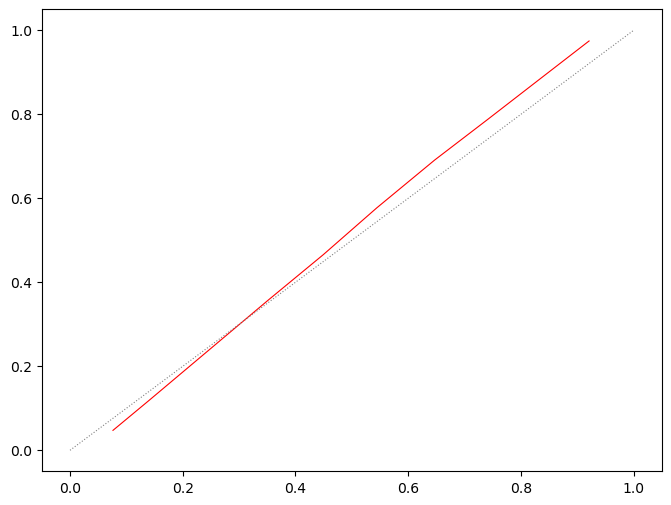

In [27]:
y_icu_pred_proba = best_lasso_icu.predict_proba(X_icu)[:, 1] 

prob_true, prob_pred = calibration_curve(y_icu, y_icu_pred_proba, n_bins=10)

# Apply LOESS smoothing
loess_fraction = 0.8  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  

## SHAP analysis

PermutationExplainer explainer: 13201it [03:49, 55.73it/s]                           


Mean SHAP values for features:
                    feature  mean_shap_value_icu
16           o2_supplement         1.241524e-01
4                   bp_dia         4.392492e-02
13                     ldh         3.335027e-02
7                     spo2         3.142843e-02
5                       rr         3.105194e-02
1                num_comor         2.735702e-02
6                     temp         1.863233e-02
3                   bp_sys         1.282879e-02
0                      age         1.263345e-02
8                  wbc_abs         1.030307e-02
17  impaired_consciousness         8.875583e-03
12                     crp         8.413673e-03
10                    urea         7.777990e-03
9             platelet_abs         6.784167e-03
11              creatinine         3.586253e-03
2                       hr         6.623528e-04
20      comor_chronic_lung         2.283114e-14
21               comor_ckd         1.803163e-14
15                sex_male         0.000000e+00
14      

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\3532590495.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_shap_values_icu, x='mean_shap_value_icu', y='feature', palette='viridis')


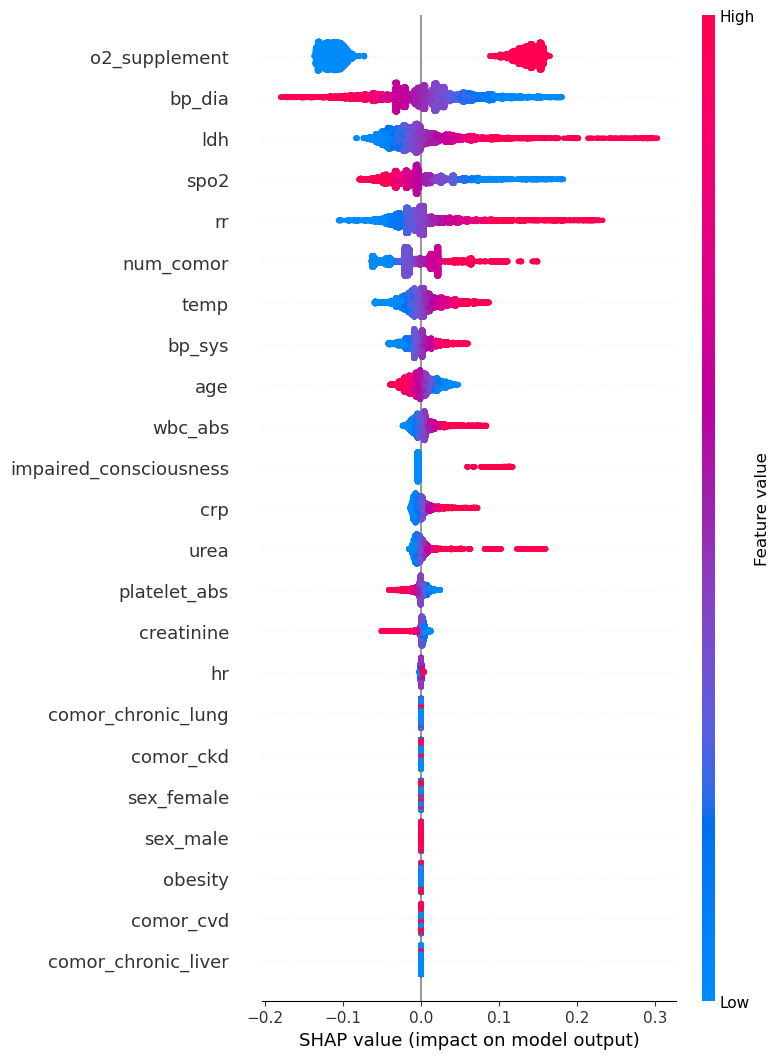

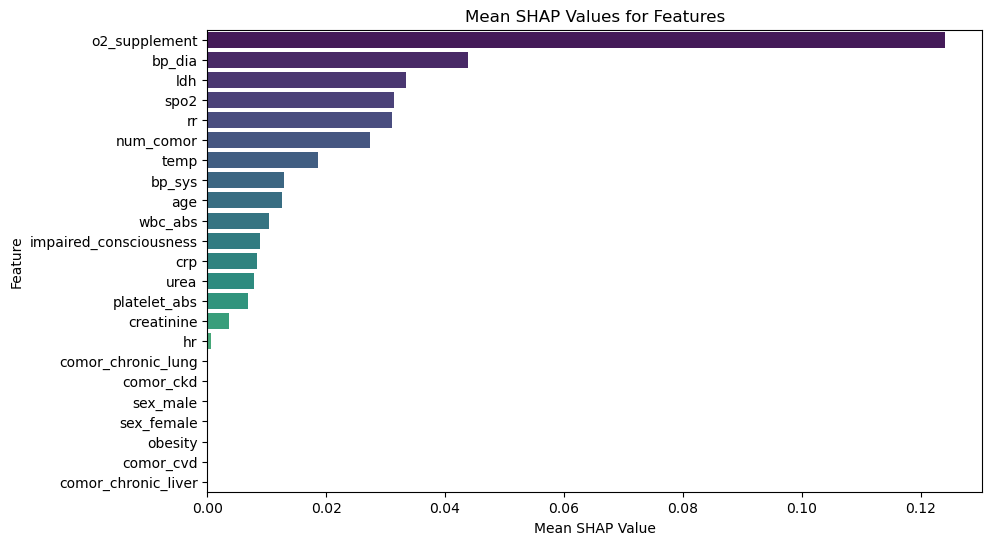

In [28]:
# Assuming best_lasso_icu and X_icu are already defined
explainer_icu = shap.Explainer(best_lasso_icu.predict_proba, X_icu)

# Calculate SHAP values
shap_values_icu = explainer_icu(X_icu)

# Extract SHAP values for the positive class (class 1)
shap_values_class_1 = shap_values_icu[..., 1]  # For binary classification

# Summary plot
shap.summary_plot(shap_values_class_1, X_icu, show=False, max_display=23)

# Calculate mean absolute SHAP values for feature importance
mean_shap_values_icu = pd.DataFrame(list(zip(feature_names, abs(shap_values_class_1.values).mean(axis=0))), 
                                    columns=['feature', 'mean_shap_value_icu'])
mean_shap_values_icu = mean_shap_values_icu.sort_values(by='mean_shap_value_icu', ascending=False)

print("Mean SHAP values for features:\n", mean_shap_values_icu)

# Plotting mean SHAP values
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_shap_values_icu, x='mean_shap_value_icu', y='feature', palette='viridis')
plt.title('Mean SHAP Values for Features')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.show()

# Extract the top 12 features based on mean SHAP values
top_12_features_shap_icu = mean_shap_values_icu['feature'].head(12).tolist()

## Train the model(after feature selection by SHAP)

In [29]:
selected_features_icu = top_12_features_shap_icu

param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}  # 'C' is the inverse of regularization strength

if True:
        # Custom scoring function that combines AUC and Calibration Intercept
    def custom_auc_calibration_intercept(y_true, y_pred_proba):
        # Calculate AUC
        auc = roc_auc_score(y_true, y_pred_proba)
        
        # Calculate Calibration Intercept
        # Fit a logistic regression model to calculate intercept
        log_reg = LogisticRegression(penalty='none', solver='newton-cg').fit(y_pred_proba.reshape(-1, 1), y_true)
        calibration_intercept = log_reg.intercept_[0]
        
        # Combine AUC and Calibration Intercept into a custom score
        # Here we subtract the absolute intercept for better calibration
        return 0.25 * auc - 0.75 * abs(calibration_intercept)
    
    # Create custom scorer
    custom_scorer = make_scorer(custom_auc_calibration_intercept, greater_is_better=True, needs_proba=True)
        
# Initialize Lasso logistic regression (L1 penalty)
if 'class_weight' in globals():  # Check if class_weight exists
    lasso_icu = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, class_weight=class_weight)
else:
    lasso_icu = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)    

# Using the custom scorer in GridSearchCV
grid_search = GridSearchCV(estimator=lasso_icu, 
                           param_grid=param_grid, 
                           #scoring = 'neg_brier_score',
                           #scoring = 'neg_log_loss',
                           #scoring='roc_auc',  # Use the custom scorer
                           scoring = custom_scorer,
                           cv=5, 
                           verbose=1,
                           n_jobs=-1)

X_icu1 = X_icu[selected_features_icu]

# Fit GridSearchCV to the data
grid_search.fit(X_icu1, y_icu)

# Now you can access the best estimator after fitting
best_lasso_icu = grid_search.best_estimator_

# Extract feature importance from the best model (coefficients for Lasso)
importances = best_lasso_icu.coef_.flatten()
feature_names = X_icu1.columns

# Create a DataFrame to store feature importances and their names
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by absolute importance and keep only the top 12 features
top_12_features_fscore_icu = importance_df.reindex(importance_df['importance'].abs().sort_values(ascending=False).index).head(12)['feature'].tolist()

print("Top 12 important features: ", top_12_features_fscore_icu)

C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Top 12 important features:  ['o2_supplement', 'impaired_consciousness', 'bp_dia', 'ldh', 'rr', 'spo2', 'num_comor', 'temp', 'bp_sys', 'age', 'wbc_abs', 'crp']


## Extract the model coefficients

In [30]:
# Extract coefficients from the best Lasso model
coefficients = best_lasso_icu.coef_.flatten()  # Flatten to get a 1D array
feature_names = X_icu1.columns  # Get the feature names from the training data

# Create a DataFrame to display the coefficients with their corresponding features
coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort the DataFrame by the absolute value of the coefficients for easier interpretation
coefficients_df = coefficients_df.reindex(coefficients_df['coefficient'].abs().sort_values(ascending=False).index)

# Display the coefficients
print(coefficients_df)

# Save the coefficients for later use if needed
coefficients_df.to_csv('lasso_coefficients.csv', index=False)


                   feature  coefficient
0            o2_supplement     1.325241
10  impaired_consciousness     0.617704
1                   bp_dia    -0.342654
2                      ldh     0.274355
4                       rr     0.242570
3                     spo2    -0.220305
5                num_comor     0.213354
6                     temp     0.157475
7                   bp_sys     0.099028
8                      age    -0.091642
9                  wbc_abs     0.075164
11                     crp     0.073680


## AUC

In [31]:
# Predict probabilities on the develoment set
X_icu = X_icu[selected_features_icu]
y_icu_pred_proba = best_lasso_icu.predict_proba(X_icu)[:, 1]  # Get probabilities for the positive class

# Calculate AUC
auc_score_icu = roc_auc_score(y_icu, y_icu_pred_proba)

print("AUC Score: ", auc_score_icu)

AUC Score:  0.8147345148140118


## Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\1961450405.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)


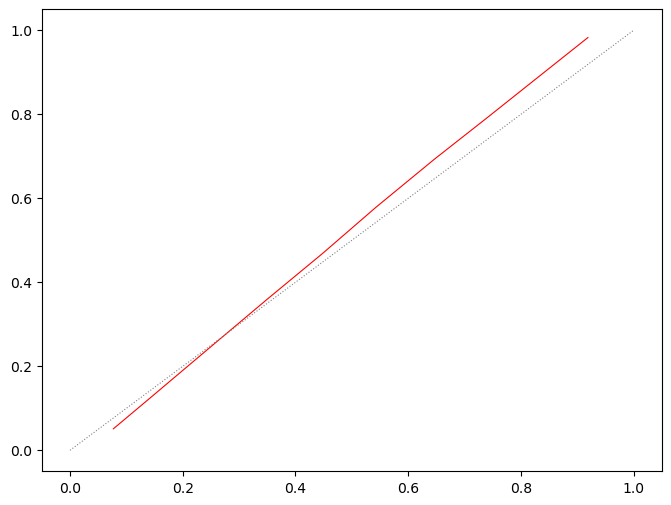

In [32]:
X_icu = X_icu[selected_features_icu]

y_icu_pred_proba = best_lasso_icu.predict_proba(X_icu)[:, 1] 

prob_true, prob_pred = calibration_curve(y_icu, y_icu_pred_proba, n_bins = 10)

# Apply LOESS smoothing
loess_fraction = 0.8  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)   

# Model evaluation

## Remove variable with missingness >= 40%

In [33]:
missing_percentage = eval_df.isna().mean()
cols_to_drop = missing_percentage[missing_percentage >= 0.4].index
eval_df = eval_df.drop(cols_to_drop, axis = 1)

## Remove outliers

In [34]:
eval_df = winso_df(eval_df, numerical_cols)

eval_df_cleaned = eval_df.copy()

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\1480996137.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[non_nan_mask] = np.where(x[non_nan_mask] > xmax, xmax, x[non_nan_mask])
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\1480996137.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[non_nan_mask] = np.where(x[non_nan_mask] < xmin, xmin, x[non_nan_mask])
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\1480996137.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[34. 71. 63. ... 68. 77. 43.]' has dtype incompati

## Evaluation for ICU

### Multiple imputation

In [35]:
# Drop the target columns
eval_df_icu = eval_df_cleaned.drop(['death_30d', 'deterioration'], axis=1)

# Define number of imputations and iterations
n_imputations = 10
max_iter = 10

# Initialize an empty list to hold all imputed datasets
imputed_eval_df = []

# Define numerical and categorical columns
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_icu = [col for col in categorical_cols if col not in ['death_30d', 'deterioration']]

# Store the target variable separately
target_variable = eval_df_icu['icu_7d'] if 'icu_7d' in eval_df_icu.columns else None

# Remove the target variable from categorical columns for imputation
if target_variable is not None:
    categorical_cols_icu.remove('icu_7d')

# Initialize IterativeImputer for continuous variables with PMM
pmm_imputer = IterativeImputer(max_iter = max_iter, random_state = 123)

# Initialize IterativeImputer for categorical variables with logistic regression
logreg_imputer = IterativeImputer(max_iter = max_iter, estimator=LogisticRegression(max_iter = 1000), random_state = 123)

# Perform multiple imputations
for i in range(n_imputations):
    # Fit and transform the continuous data
    imputed_numerical = pmm_imputer.fit_transform(eval_df_icu[numerical_cols])
    imputed_categorical = logreg_imputer.fit_transform(eval_df_icu[categorical_cols_icu])
    
    # Convert to DataFrame and store
    imputed_numerical_df = pd.DataFrame(imputed_numerical, columns = numerical_cols)
    imputed_categorical_df = pd.DataFrame(imputed_categorical, columns = categorical_cols_icu)
    
    # Combine the imputed numerical and categorical DataFrames
    combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis = 1)
    
    # If the target variable exists, add it back to the combined DataFrame
    if target_variable is not None:
        combined_imputed_df['icu_7d'] = target_variable.values
    
    # Append the combined DataFrame to the list
    imputed_eval_df.append(combined_imputed_df)

# Stack all imputed datasets into one DataFrame
combined_imputed_eval_df = pd.concat(imputed_eval_df, ignore_index=True)

In [36]:
if False:

    # Drop the target columns
    eval_df_cleaned.drop(['death_30d', 'deterioration'], axis=1, inplace=True)
    
    # Define number of imputations and iterations
    n_imputations = 10
    max_iter = 10
    
    # Initialize an empty list to hold all imputed datasets
    imputed_eval_df = []
    
    # Define numerical and categorical columns
    numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
    categorical_cols_icu = [col for col in categorical_cols if col not in ['death_30d', 'deterioration']]
    
    # Initialize IterativeImputer for continuous variables with PMM
    pmm_imputer = IterativeImputer(max_iter=max_iter, random_state=123)
    
    # Initialize IterativeImputer for categorical variables with logistic regression
    logreg_imputer = IterativeImputer(max_iter=max_iter, estimator=LogisticRegression(max_iter=1000), random_state=123)

    # Perform multiple imputations for continuous variables
    for i in range(n_imputations):
        # Fit and transform the continuous data
        imputed_numerical = pmm_imputer.fit_transform(eval_df_cleaned[numerical_cols])
        imputed_categorical = logreg_imputer.fit_transform(eval_df_cleaned[categorical_cols_icu])
        
        # Convert to DataFrame and store
        imputed_numerical_df = pd.DataFrame(imputed_numerical, columns=numerical_cols)
        imputed_categorical_df = pd.DataFrame(imputed_categorical, columns=categorical_cols_icu)
        
        # Combine the imputed numerical and categorical DataFrames
        combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis=1)
        
        # Append the combined DataFrame to the list
        imputed_eval_df.append(combined_imputed_df)
    
    # Stack all imputed datasets into one DataFrame
    combined_imputed_eval_df = pd.concat(imputed_eval_df, ignore_index=True)

### Data normalization

In [37]:
categorical_cols_icu.append('icu_7d')

# Apply the same StandardScaler (already fitted on dev_df) to eval_df
scaled_numeric_eval_data = scaler.transform(combined_imputed_eval_df[numerical_cols])

# Convert the scaled numeric data back to a DataFrame
scaled_numeric_eval_df = pd.DataFrame(scaled_numeric_eval_data, columns = numerical_cols)

# Recombine the standardized numeric columns with the original unchanged categorical columns in eval_df
standardized_eval_df = pd.concat([scaled_numeric_eval_df.reset_index(drop=True), 
                                  combined_imputed_eval_df[categorical_cols_icu].reset_index(drop=True)], axis=1)

# Display the standardized eval DataFrame
print(standardized_eval_df)


            age  num_comor        hr    bp_sys    bp_dia        rr      temp  \
0     -1.464388  -0.421055  0.401980  0.259910 -0.346733 -1.236146 -0.428107   
1      0.731857  -0.421055  1.341009  0.962978  1.061566  1.685981  2.745900   
2      0.256993   0.205518 -0.724855 -1.687045 -1.578995  2.540847 -0.994894   
3     -0.158513   1.672809 -0.787457 -0.010500 -0.082677  0.022852  0.932182   
4      0.613141   0.353772 -0.724855 -1.470717 -0.786826 -1.236146 -0.541464   
...         ...        ...       ...       ...       ...       ...       ...   
10775 -0.811450  -1.467988  0.527184 -0.118664  0.093361  0.232685  0.592110   
10776  0.494425  -1.467988  0.589786 -0.983978 -0.698808 -1.026313  0.025323   
10777  0.553783  -0.421055 -0.474447 -0.929896 -0.346733 -0.396814 -1.448323   
10778  1.088004   0.625877 -0.599651 -0.605403 -0.874845  0.022852 -0.314749   
10779 -0.930166  -0.403031 -1.163068  0.151746  0.533454 -0.606647 -1.221609   

           spo2   wbc_abs  platelet_abs

### Split the eval_df into features and target

In [38]:
X_eval_icu = standardized_eval_df.drop(['icu_7d'], axis = 1).copy()  # Features (drop the target column)

X_eval_icu = X_eval_icu[selected_features_icu]

In [39]:
y_eval_icu = standardized_eval_df ['icu_7d'].copy()

In [40]:
# Calculate the prevalence in preparation for DCA
y_eval_icu = np.array(y_eval_icu)

# Calculate the positive rate
prevalence = np.mean(y_eval_icu)

### AUC computation

In [41]:
# Predict probabilities on the validation set
y_eval_icu_pred_proba = best_lasso_icu.predict_proba(X_eval_icu)[:, 1]  # Get probabilities for the positive class

# Calculate AUC
auc_score_icu = roc_auc_score(y_eval_icu, y_eval_icu_pred_proba)

print("AUC Score: ", auc_score_icu)

AUC Score:  0.7643305799346066


### Calibration in the large

In [42]:
calibration_in_the_large = np.mean(y_eval_icu_pred_proba) - np.mean(y_eval_icu)
print("Calibration in the Large: ", calibration_in_the_large)

Calibration in the Large:  0.06593867920175983


### Calibration intercept and slope

In [43]:
# Assuming y_eval_icu is the observed outcome (0 or 1)
# and y_eval_icu_pred_proba is the predicted probability from your model

# Convert predicted probabilities to log-odds
log_odds = np.log(y_eval_icu_pred_proba / (1 - y_eval_icu_pred_proba))

# Add a constant term for the intercept in the logistic regression model
X_log_odds = sm.add_constant(log_odds)

# Fit the logistic regression model
model = sm.Logit(y_eval_icu, X_log_odds).fit(disp=0)  # disp=0 suppresses output during fitting

# Extract the intercept and slope
calibration_intercept = model.params[0]  # Intercept
calibration_slope = model.params[1]      # Slope

print("Calibration Intercept: ", calibration_intercept)
print("Calibration Slope: ", calibration_slope)

Calibration Intercept:  -0.49265550571969213
Calibration Slope:  0.8063512379753618


In [44]:
if False:

    # Predict probabilities on the validation set
    y_eval_icu_pred_proba = best_lasso_icu.predict_proba(X_eval_icu)[:, 1]  # Probabilities for the positive class
    
    # To calculate calibration intercept and slope:
    # 1. Take the logit (log-odds) of the predicted probabilities
    logit_pred_proba = np.log(y_eval_icu_pred_proba / (1 - y_eval_icu_pred_proba))
    
    # 2. Reshape and standardize the logit predictions
    logit_pred_proba = logit_pred_proba.reshape(-1, 1)
    scaler_cali = StandardScaler()
    logit_pred_proba_scaled = scaler_cali.fit_transform(logit_pred_proba)
    
    # 3. Fit a logistic regression model to assess calibration
    calibration_model = LogisticRegression(fit_intercept=True)
    calibration_model.fit(logit_pred_proba_scaled, y_eval_icu)
    
    # 4. Extract calibration intercept and slope
    calibration_intercept = calibration_model.intercept_[0]
    calibration_slope = calibration_model.coef_[0][0]
    
    print("Calibration Intercept: ", calibration_intercept)
    print("Calibration Slope: ", calibration_slope)
    
    # Convert intercept back to probability
    original_intercept_probability = 1 / (1 + np.exp(-calibration_intercept))
    print("Calibration Intercept (Probability Scale): ", original_intercept_probability)


### Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\4190602784.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration


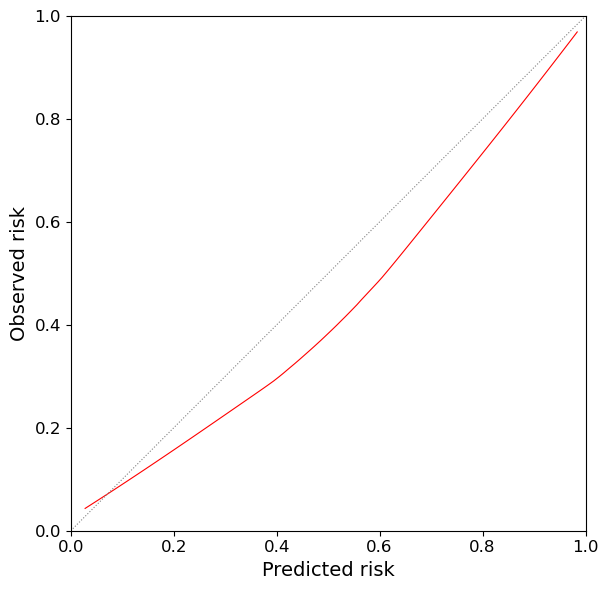

In [45]:
# Compute the calibration curve
prob_true, prob_pred = calibration_curve(y_eval_icu, y_eval_icu_pred_proba, n_bins = 100)

# Apply LOESS smoothing
loess_fraction = 0.8  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration

# Set limits and ensure equal unit lengths on both axes
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable = 'box')  # This ensures equal scaling of both axes

plt.xlabel('Predicted risk', fontsize = 14)
plt.ylabel('Observed risk', fontsize = 14)
plt.xticks(fontsize = 12)  # Adjust font size for x-axis tick labels
plt.yticks(fontsize = 12)  # Adjust font size for y-axis tick labels
#plt.title('Calibration Plot', fontsize=16)
#plt.legend(loc="best", fontsize = 12)
plt.grid(False)
plt.tight_layout()

# Show plot
plt.grid(False)
plt.savefig(r'T:\Projects\NAPKON\projects\CROSS_mortality\python\results\figures\xgboost_mortality\calibration_plot_12FeaturesbyFscore.png', bbox_inches='tight')
plt.show()


### Brier score

In [46]:
# Get probabilities for the positive class
y_eval_icu_pred_proba = best_lasso_icu.predict_proba(X_eval_icu)[:, 1]

# Calculate Brier score
brier_score = brier_score_loss(y_eval_icu, y_eval_icu_pred_proba)

print(f"Brier Score: {brier_score}")

Brier Score: 0.16777366992945547


### SHAP analysis

PermutationExplainer explainer: 10781it [04:46, 36.27it/s]                           


Mean SHAP values for features:
                    feature  mean_shap_value_icu
0            o2_supplement             0.124157
1                   bp_dia             0.051041
2                      ldh             0.043976
4                       rr             0.040627
3                     spo2             0.029501
11                     crp             0.027800
5                num_comor             0.027645
6                     temp             0.022203
10  impaired_consciousness             0.016569
7                   bp_sys             0.014914
8                      age             0.011746
9                  wbc_abs             0.011166


C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\3793200553.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_shap_values_icu, x='mean_shap_value_icu', y='feature', palette='viridis')


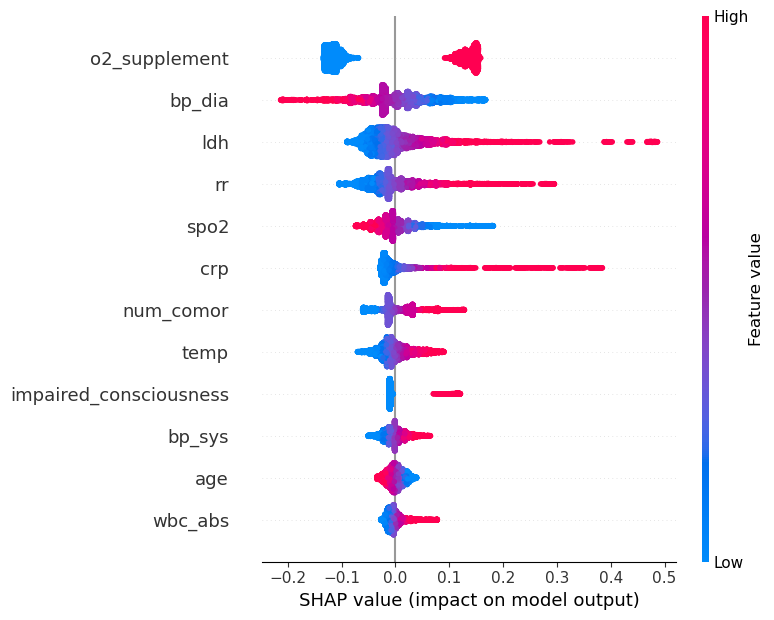

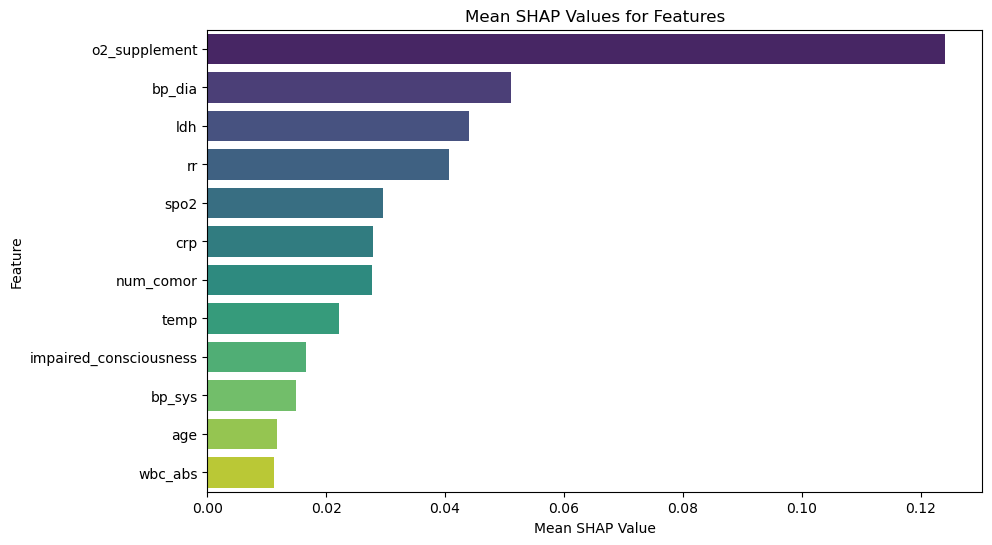

In [47]:
# Assuming best_lasso_icu and X_icu are already defined
explainer_icu = shap.Explainer(best_lasso_icu.predict_proba, X_eval_icu)

# Calculate SHAP values
shap_values_icu = explainer_icu(X_eval_icu)

# Extract SHAP values for the positive class (class 1)
shap_values_class_1 = shap_values_icu[..., 1]  # For binary classification

# Summary plot
shap.summary_plot(shap_values_class_1, X_eval_icu, show=False, max_display=23)

# Calculate mean absolute SHAP values for feature importance
mean_shap_values_icu = pd.DataFrame(list(zip(feature_names, abs(shap_values_class_1.values).mean(axis=0))), 
                                    columns=['feature', 'mean_shap_value_icu'])
mean_shap_values_icu = mean_shap_values_icu.sort_values(by='mean_shap_value_icu', ascending=False)

print("Mean SHAP values for features:\n", mean_shap_values_icu)

# Plotting mean SHAP values
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_shap_values_icu, x='mean_shap_value_icu', y='feature', palette='viridis')
plt.title('Mean SHAP Values for Features')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.show()

# Extract the top 12 features based on mean SHAP values
top_12_features_shap_icu = mean_shap_values_icu['feature'].head(12).tolist()

### LIME analysis

In [48]:
# Create a LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_eval_icu.values,
    feature_names=X_eval_icu.columns,
    class_names=['Negative', 'Positive'],  # Modify as needed for binary classes
    mode='classification'
)

# Select an instance to explain
instance_to_explain = X_eval_icu.iloc[0]

# Explain the prediction for the selected instance
lime_exp = lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=best_lasso_icu.predict_proba,
    num_features=12  # Specify the number of features to display
)

# Show the explanation
lime_exp.show_in_notebook(show_table=True)

# Print feature importance for the explained instance
print("LIME feature importance for the selected instance:")
for feature, importance in lime_exp.as_list():
    print(f"{feature}: {importance}")

C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

LIME feature importance for the selected instance:
0.00 < o2_supplement <= 1.00: 0.2575363443565732
ldh > 0.52: 0.15441416082331844
impaired_consciousness > 0.00: 0.13119864119695338
rr <= -0.62: -0.08724971616076477
num_comor <= -0.42: -0.06016616533027394
crp <= -0.73: -0.05619595774311622
age <= -0.69: 0.03213622986280703
wbc_abs > 0.35: 0.025187848663608035
-0.61 < bp_dia <= 0.09: 0.022228793283994117
-0.54 < temp <= -0.09: -0.011371663979509106
-0.63 < spo2 <= -0.01: 0.004413832976964188
0.04 < bp_sys <= 0.69: 0.003511509407440428


#### LIME visualization

C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\xiangw\AppData\Local\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

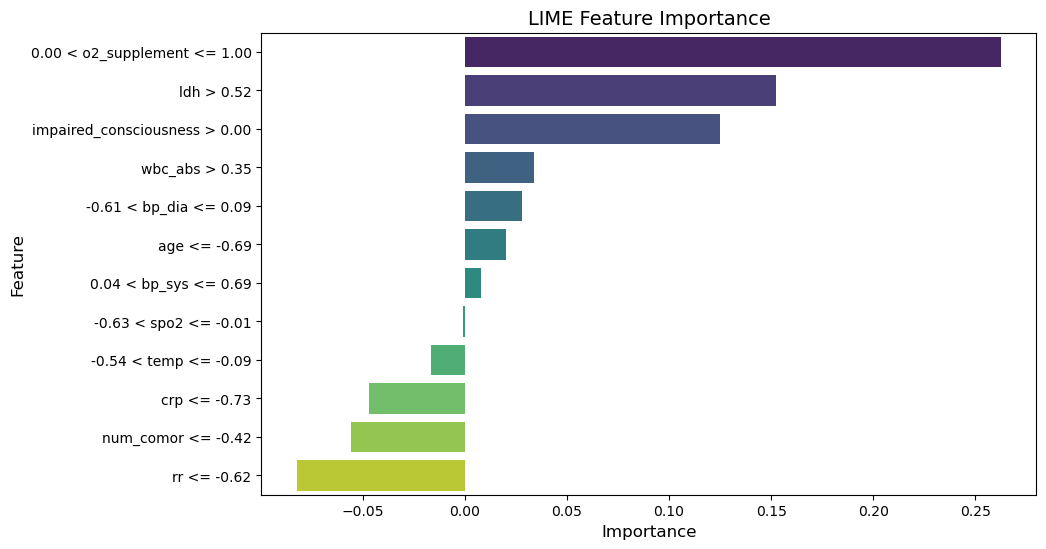

In [49]:
# Create a LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_eval_icu.values,
    feature_names=X_eval_icu.columns,
    class_names=['Negative', 'Positive'],  # Modify as needed for binary classes
    mode='classification'
)

# Select an instance to explain
instance_to_explain = X_eval_icu.iloc[0]

# Explain the prediction for the selected instance
lime_exp = lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=best_lasso_icu.predict_proba,
    num_features=12  # Specify the number of features to display
)

# Get the explanation as a list of features and importance values
lime_feature_importance = lime_exp.as_list()

# Separate features and importance values
features, importance = zip(*lime_feature_importance)

# Create a pandas DataFrame for easy plotting
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

# Customize the background and text colors
plt.gca().set_facecolor('white')  # Set background color to white
plt.gca().tick_params(axis='y', labelcolor='black')  # Set text color to black
plt.gca().tick_params(axis='x', labelcolor='black')  # Set text color to black
plt.xlabel('Importance', fontsize=12, color='black')  # Set label color to black
plt.ylabel('Feature', fontsize=12, color='black')  # Set label color to black
plt.title('LIME Feature Importance', fontsize=14, color='black')  # Set title color to black

# Show the plot
plt.show()

### Permutation importance

Permutation feature importances:
                    feature  importance
0            o2_supplement    0.081116
2                      ldh    0.015206
1                   bp_dia    0.014296
4                       rr    0.014051
10  impaired_consciousness    0.010918
11                     crp    0.009707
5                num_comor    0.004682
7                   bp_sys    0.004268
9                  wbc_abs    0.002546
6                     temp    0.001962
8                      age    0.001438
3                     spo2    0.000915


C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\1449976077.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_importance_df, x='importance', y='feature', palette='Blues_r')


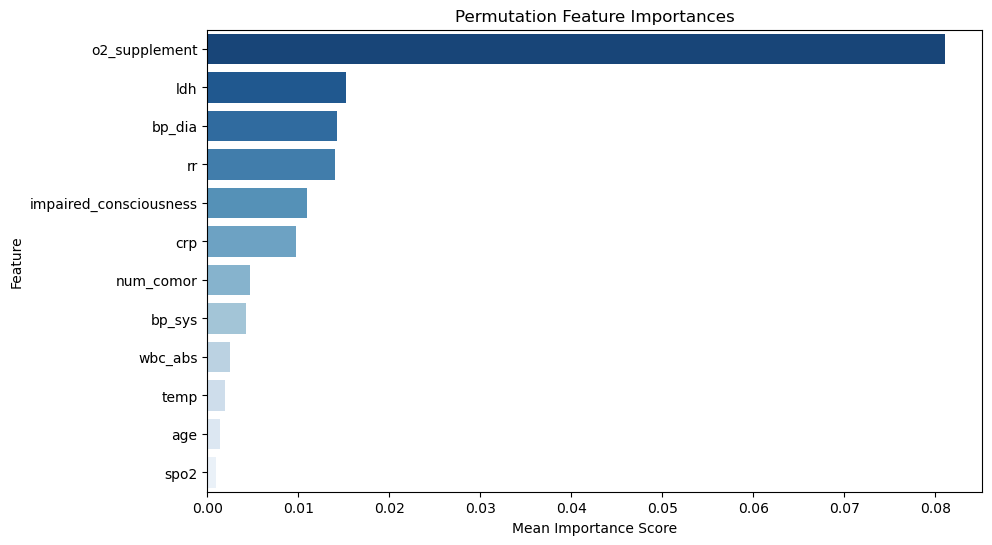

In [50]:
# Compute permutation importance
perm_importance = permutation_importance(
    estimator=best_lasso_icu,
    X=X_eval_icu,
    y=y_eval_icu,
    n_repeats=30,
    random_state=42,
    scoring='roc_auc'
)

# Create a DataFrame to display permutation importances
perm_importance_df = pd.DataFrame({
    'feature': X_eval_icu.columns,
    'importance': perm_importance.importances_mean
})

# Sort by the mean importance score
perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)

# Print and plot permutation importance
print("Permutation feature importances:\n", perm_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=perm_importance_df, x='importance', y='feature', palette='Blues_r')
plt.title('Permutation Feature Importances')
plt.xlabel('Mean Importance Score')
plt.ylabel('Feature')
plt.show()

# Extract the top 12 features based on permutation importance
top_12_features_perm_importance = perm_importance_df['feature'].head(12).tolist()


### Decision curve analysis

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\2512470326.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  nb = tp / len(data) - (fp / len(data)) * (threshold / (1 - threshold))
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\2512470326.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  nb = tp / len(data) - (fp / len(data)) * (threshold / (1 - threshold))
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\2512470326.py:18: RuntimeWarning: divide by zero encountered in divide
  return prevalence - (1 - prevalence) * (threshold_probs / (1 - threshold_probs))


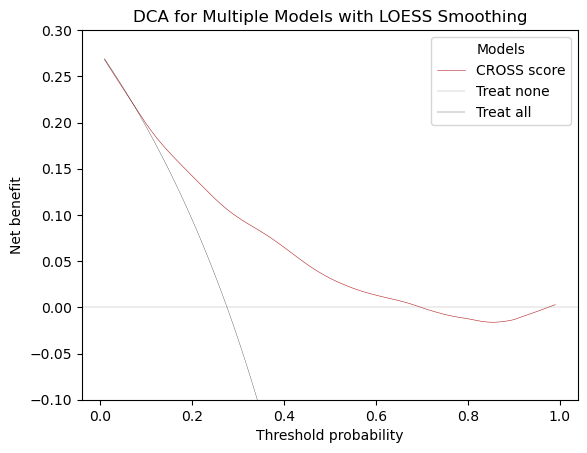

In [51]:
# Assuming `y_eval_icu` (ground truth) and `y_eval_icu_pred_proba` (predicted probabilities) are available
dat_all = pd.DataFrame({'icu_7d': y_eval_icu, 'der_pred_cross': y_eval_icu_pred_proba})

prevalence = prevalence

# Function to calculate net benefit for decision curve analysis
def decision_curve_analysis(data, threshold_probs, prevalence = prevalence):
    net_benefits = []
    for threshold in threshold_probs:
        tp = np.sum((data['der_pred_cross'] >= threshold) & (data['icu_7d'] == 1))
        fp = np.sum((data['der_pred_cross'] >= threshold) & (data['icu_7d'] == 0))
        nb = tp / len(data) - (fp / len(data)) * (threshold / (1 - threshold))
        net_benefits.append(nb)
    return pd.DataFrame({'threshold': threshold_probs, 'net_benefit': net_benefits})

# Function to calculate the net benefit for the "Treat All" strategy
def treat_all_line(threshold_probs, prevalence):
    return prevalence - (1 - prevalence) * (threshold_probs / (1 - threshold_probs))

# Define threshold probabilities for DCA
threshold_probs = np.linspace(0.01, 1.0, 100)

# Perform decision curve analysis
df_plot = decision_curve_analysis(dat_all, threshold_probs, prevalence)

# Calculate the "Treat All" line using the correct formula
df_plot['treat_all'] = treat_all_line(threshold_probs, prevalence)

# Apply LOESS smoothing to net benefit
loess_smoothed = lowess(df_plot['net_benefit'], df_plot['threshold'], frac=0.2)  # frac controls the amount of smoothing

# Prepare smoothed results for plotting
smoothed_df = pd.DataFrame(loess_smoothed, columns=['threshold', 'smoothed_net_benefit'])

# Color and linetype mapping for the plot
color_labels = {
    'der_pred_cross': '#B22222',  # Red color for CROSS score
    'Treat All': '#000000',        # Black color for Treat All
    'Treat None': '#808080'        # Grey color for Treat None
}
linetype_labels = {
    'der_pred_cross': 'solid',
    'Treat All': 'solid',
    'Treat None': 'solid'
}
legend_labels = {
    'der_pred_cross': 'CROSS score',
    'Treat All': 'Treat all',
    'Treat None': 'Treat none'
}

# Plot the LOESS smoothed net benefit for CROSS score (DCA curve)
sns.lineplot(data=smoothed_df, 
             x='threshold', 
             y='smoothed_net_benefit', 
             label=legend_labels['der_pred_cross'], 
             color=color_labels['der_pred_cross'], 
             linestyle=linetype_labels['der_pred_cross'], 
             linewidth=0.4)  

# Plot the Treat None line (always at y = 0)
plt.axhline(y=0, 
            color=color_labels['Treat None'], 
            linestyle='solid', 
            label=legend_labels['Treat None'], 
            linewidth=0.2)  

# Plot the Treat All line (calculated as a slant line)
sns.lineplot(x=threshold_probs, 
             y=df_plot['treat_all'], 
             label=legend_labels['Treat All'], 
             color=color_labels['Treat All'], 
             linestyle=linetype_labels['Treat All'], 
             linewidth=0.2)  

# Customize plot
plt.title("DCA for Multiple Models with LOESS Smoothing")
plt.xlabel("Threshold probability")
plt.ylabel("Net benefit")
plt.ylim(-0.1, 0.3)  # Adjust y-limits if necessary
plt.legend(title="Models")

# Show plot
plt.show()


## Evaluation for mortality

### Multiple imputation

In [52]:
# Drop the target columns
eval_df_mortality = eval_df_cleaned.drop(['icu_7d', 'deterioration'], axis = 1)

# Define number of imputations and iterations
n_imputations = 10
max_iter = 10

# Initialize an empty list to hold all imputed datasets
imputed_eval_df = []

# Define numerical and categorical columns
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_mortality = [col for col in categorical_cols if col not in ['icu_7d', 'deterioration']]

# Store the target variable separately
target_variable = eval_df_mortality['death_30d'] if 'death_30d' in eval_df_mortality.columns else None

# Remove the target variable from categorical columns for imputation
if target_variable is not None:
    categorical_cols_mortality.remove('death_30d')

# Initialize IterativeImputer for continuous variables with PMM
pmm_imputer = IterativeImputer(max_iter=max_iter, random_state=123)

# Initialize IterativeImputer for categorical variables with logistic regression
logreg_imputer = IterativeImputer(max_iter=max_iter, estimator=LogisticRegression(max_iter=1000), random_state=123)

# Perform multiple imputations
for i in range(n_imputations):
    # Fit and transform the continuous data
    imputed_numerical = pmm_imputer.fit_transform(eval_df_mortality[numerical_cols])
    imputed_categorical = logreg_imputer.fit_transform(eval_df_mortality[categorical_cols_mortality])
    
    # Convert to DataFrame and store
    imputed_numerical_df = pd.DataFrame(imputed_numerical, columns=numerical_cols)
    imputed_categorical_df = pd.DataFrame(imputed_categorical, columns=categorical_cols_mortality)
    
    # Combine the imputed numerical and categorical DataFrames
    combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis=1)
    
    # If the target variable exists, add it back to the combined DataFrame
    if target_variable is not None:
        combined_imputed_df['death_30d'] = target_variable.values
    
    # Append the combined DataFrame to the list
    imputed_eval_df.append(combined_imputed_df)

# Stack all imputed datasets into one DataFrame
combined_imputed_eval_df = pd.concat(imputed_eval_df, ignore_index=True)

### Data normalization

In [53]:
categorical_cols_mortality.append('death_30d')

# Apply the same StandardScaler (already fitted on dev_df) to eval_df
scaled_numeric_eval_data = scaler.transform(combined_imputed_eval_df[numerical_cols])

# Convert the scaled numeric data back to a DataFrame
scaled_numeric_eval_df = pd.DataFrame(scaled_numeric_eval_data, columns = numerical_cols)

# Recombine the standardized numeric columns with the original unchanged categorical columns in eval_df
standardized_eval_df = pd.concat([scaled_numeric_eval_df.reset_index(drop=True), 
                                  combined_imputed_eval_df[categorical_cols_mortality].reset_index(drop=True)], axis=1)

# Display the standardized eval DataFrame
print(standardized_eval_df)

            age  num_comor        hr    bp_sys    bp_dia        rr      temp  \
0     -1.464388  -0.421055  0.401980  0.259910 -0.346733 -1.236146 -0.428107   
1      0.731857  -0.421055  1.341009  0.962978  1.061566  1.685981  2.745900   
2      0.256993   0.205518 -0.724855 -1.687045 -1.578995  2.540847 -0.994894   
3     -0.158513   1.672809 -0.787457 -0.010500 -0.082677  0.022852  0.932182   
4      0.613141   0.353772 -0.724855 -1.470717 -0.786826 -1.236146 -0.541464   
...         ...        ...       ...       ...       ...       ...       ...   
10775 -0.811450  -1.467988  0.527184 -0.118664  0.093361  0.232685  0.592110   
10776  0.494425  -1.467988  0.589786 -0.983978 -0.698808 -1.026313  0.025323   
10777  0.553783  -0.421055 -0.474447 -0.929896 -0.346733 -0.396814 -1.448323   
10778  1.088004   0.625877 -0.599651 -0.605403 -0.874845  0.022852 -0.314749   
10779 -0.930166  -0.403031 -1.163068  0.151746  0.533454 -0.606647 -1.221609   

           spo2   wbc_abs  platelet_abs

### Split the eval_df into features and target

In [54]:
X_eval_mortality = standardized_eval_df.drop(['death_30d'], axis = 1).copy()  # Features (drop the target column)

X_eval_mortality = X_eval_mortality[selected_features_icu]

In [55]:
y_eval_mortality = standardized_eval_df ['death_30d'].copy()

In [56]:
# Compute the prevalence in preparation for DCA
y_eval_mortality = np.array(y_eval_mortality)

# Calculate the positive rate
prevalence = np.mean(y_eval_mortality)

### AUC computation

In [57]:
# Predict probabilities on the validation set
y_eval_mortality_pred_proba = best_lasso_icu.predict_proba(X_eval_mortality)[:, 1]  # Get probabilities for the positive class

# Calculate AUC
auc_score_mortality = roc_auc_score(y_eval_mortality, y_eval_mortality_pred_proba)

print("AUC Score: ", auc_score_mortality)

AUC Score:  0.8176657670328557


### Calibration in the large

In [58]:
calibration_in_the_large = np.mean(y_eval_mortality_pred_proba) - np.mean(y_eval_mortality)
print("Calibration in the Large: ", calibration_in_the_large)

Calibration in the Large:  0.2690926680700344


### Calibration intercept and slope

In [59]:
# Assuming y_eval_icu is the observed outcome (0 or 1)
# and y_eval_icu_pred_proba is the predicted probability from your model

# Convert predicted probabilities to log-odds
log_odds = np.log(y_eval_mortality_pred_proba / (1 - y_eval_mortality_pred_proba))

# Add a constant term for the intercept in the logistic regression model
X_log_odds = sm.add_constant(log_odds)

# Fit the logistic regression model
model = sm.Logit(y_eval_mortality, X_log_odds).fit(disp=0)  # disp=0 suppresses output during fitting

# Extract the intercept and slope
calibration_intercept = model.params[0]  # Intercept
calibration_slope = model.params[1]      # Slope

print("Calibration Intercept: ", calibration_intercept)
print("Calibration Slope: ", calibration_slope)

Calibration Intercept:  -2.388043217626097
Calibration Slope:  0.8798670503679479


In [60]:
if False:
    
    # Predict probabilities on the validation set
    y_eval_mortality_pred_proba = best_lasso_icu.predict_proba(X_eval_mortality)[:, 1]  # Probabilities for the positive class
    
    # To calculate calibration intercept and slope:
    # 1. Take the logit (log-odds) of the predicted probabilities
    logit_pred_proba = np.log(y_eval_mortality_pred_proba / (1 - y_eval_mortality_pred_proba))
    
    # 2. Reshape and standardize the logit predictions
    logit_pred_proba = logit_pred_proba.reshape(-1, 1)
    scaler_cali = StandardScaler()
    logit_pred_proba_scaled = scaler_cali.fit_transform(logit_pred_proba)
    
    # 3. Fit a logistic regression model to assess calibration
    calibration_model = LogisticRegression(fit_intercept=True)
    calibration_model.fit(logit_pred_proba_scaled, y_eval_mortality)
    
    # 4. Extract calibration intercept and slope
    calibration_intercept = calibration_model.intercept_[0]
    calibration_slope = calibration_model.coef_[0][0]
    
    print("Calibration Intercept: ", calibration_intercept)
    print("Calibration Slope: ", calibration_slope)
    
    # Convert intercept back to probability
    original_intercept_probability = 1 / (1 + np.exp(-calibration_intercept))
    print("Calibration Intercept (Probability Scale): ", original_intercept_probability)

### Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\4135521267.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration


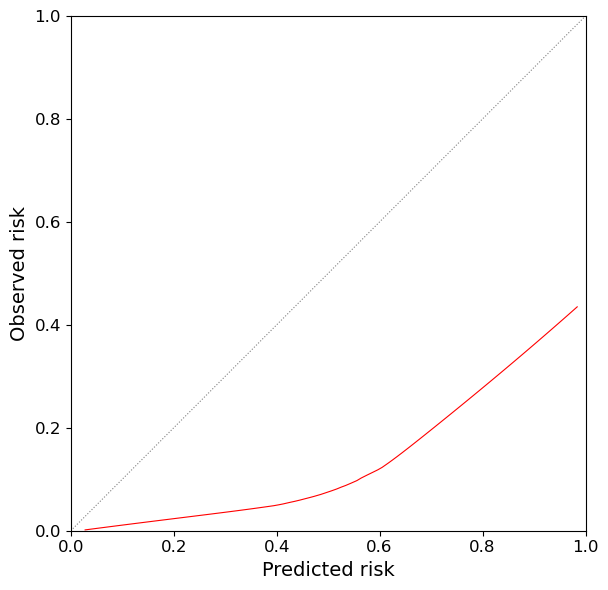

In [61]:
# Compute the calibration curve
prob_true, prob_pred = calibration_curve(y_eval_mortality, y_eval_mortality_pred_proba, n_bins = 100)

# Apply LOESS smoothing
loess_fraction = 0.8  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration

# Set limits and ensure equal unit lengths on both axes
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable = 'box')  # This ensures equal scaling of both axes

plt.xlabel('Predicted risk', fontsize = 14)
plt.ylabel('Observed risk', fontsize = 14)
plt.xticks(fontsize = 12)  # Adjust font size for x-axis tick labels
plt.yticks(fontsize = 12)  # Adjust font size for y-axis tick labels
#plt.title('Calibration Plot', fontsize=16)
#plt.legend(loc="best", fontsize = 12)
plt.grid(False)
plt.tight_layout()

# Show plot
plt.grid(False)
plt.savefig(r'T:\Projects\NAPKON\projects\CROSS_mortality\python\results\figures\xgboost_mortality\calibration_plot_12FeaturesbyFscore.png', bbox_inches='tight')
plt.show()

### Brier score

In [62]:
# Get probabilities for the positive class
y_eval_mortality_pred_proba = best_lasso_icu.predict_proba(X_eval_mortality)[:, 1]

# Calculate Brier score
brier_score = brier_score_loss(y_eval_mortality, y_eval_mortality_pred_proba)

print(f"Brier Score: {brier_score}")

Brier Score: 0.1581501282327266


### Decision curve analysis

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\909604892.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  nb = tp / len(data) - (fp / len(data)) * (threshold / (1 - threshold))
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\909604892.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  nb = tp / len(data) - (fp / len(data)) * (threshold / (1 - threshold))
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\909604892.py:18: RuntimeWarning: divide by zero encountered in divide
  return prevalence - (1 - prevalence) * (threshold_probs / (1 - threshold_probs))


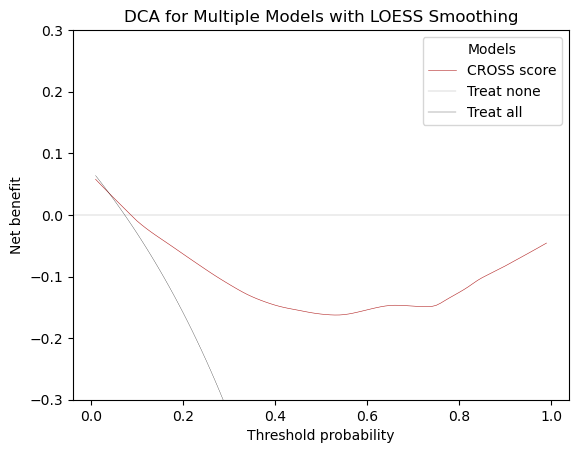

In [63]:
# Assuming `y_eval_icu` (ground truth) and `y_eval_icu_pred_proba` (predicted probabilities) are available
dat_all = pd.DataFrame({'death_30d': y_eval_mortality, 'der_pred_cross': y_eval_mortality_pred_proba})

prevalence = prevalence

# Function to calculate net benefit for decision curve analysis
def decision_curve_analysis(data, threshold_probs, prevalence = prevalence):
    net_benefits = []
    for threshold in threshold_probs:
        tp = np.sum((data['der_pred_cross'] >= threshold) & (data['death_30d'] == 1))
        fp = np.sum((data['der_pred_cross'] >= threshold) & (data['death_30d'] == 0))
        nb = tp / len(data) - (fp / len(data)) * (threshold / (1 - threshold))
        net_benefits.append(nb)
    return pd.DataFrame({'threshold': threshold_probs, 'net_benefit': net_benefits})

# Function to calculate the net benefit for the "Treat All" strategy
def treat_all_line(threshold_probs, prevalence):
    return prevalence - (1 - prevalence) * (threshold_probs / (1 - threshold_probs))

# Define threshold probabilities for DCA
threshold_probs = np.linspace(0.01, 1.0, 100)

# Perform decision curve analysis
df_plot = decision_curve_analysis(dat_all, threshold_probs, prevalence)

# Calculate the "Treat All" line using the correct formula
df_plot['treat_all'] = treat_all_line(threshold_probs, prevalence)

# Apply LOESS smoothing to net benefit
loess_smoothed = lowess(df_plot['net_benefit'], df_plot['threshold'], frac=0.2)  # frac controls the amount of smoothing

# Prepare smoothed results for plotting
smoothed_df = pd.DataFrame(loess_smoothed, columns=['threshold', 'smoothed_net_benefit'])

# Color and linetype mapping for the plot
color_labels = {
    'der_pred_cross': '#B22222',  # Red color for CROSS score
    'Treat All': '#000000',        # Black color for Treat All
    'Treat None': '#808080'        # Grey color for Treat None
}
linetype_labels = {
    'der_pred_cross': 'solid',
    'Treat All': 'solid',
    'Treat None': 'solid'
}
legend_labels = {
    'der_pred_cross': 'CROSS score',
    'Treat All': 'Treat all',
    'Treat None': 'Treat none'
}

# Plot the LOESS smoothed net benefit for CROSS score (DCA curve)
sns.lineplot(data=smoothed_df, 
             x='threshold', 
             y='smoothed_net_benefit', 
             label=legend_labels['der_pred_cross'], 
             color=color_labels['der_pred_cross'], 
             linestyle=linetype_labels['der_pred_cross'], 
             linewidth=0.4)  

# Plot the Treat None line (always at y = 0)
plt.axhline(y=0, 
            color=color_labels['Treat None'], 
            linestyle='solid', 
            label=legend_labels['Treat None'], 
            linewidth=0.2)  

# Plot the Treat All line (calculated as a slant line)
sns.lineplot(x=threshold_probs, 
             y=df_plot['treat_all'], 
             label=legend_labels['Treat All'], 
             color=color_labels['Treat All'], 
             linestyle=linetype_labels['Treat All'], 
             linewidth=0.2)  

# Customize plot
plt.title("DCA for Multiple Models with LOESS Smoothing")
plt.xlabel("Threshold probability")
plt.ylabel("Net benefit")
plt.ylim(-0.3, 0.3)  # Adjust y-limits if necessary
plt.legend(title="Models")

# Show plot
plt.show()


## Evaluation for deterioration

### Multiple imputation

In [64]:
# Drop the target columns
eval_df_deterioration = eval_df_cleaned.drop(['death_30d', 'icu_7d'], axis=1)

# Define number of imputations and iterations
n_imputations = 10
max_iter = 10

# Initialize an empty list to hold all imputed datasets
imputed_eval_df = []

# Define numerical and categorical columns
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_deterioration = [col for col in categorical_cols if col not in ['death_30d', 'icu_7d']]

# Store the target variable separately
target_variable = eval_df_deterioration['deterioration'] if 'deterioration' in eval_df_deterioration.columns else None

# Remove the target variable from categorical columns for imputation
if target_variable is not None:
    categorical_cols_deterioration.remove('deterioration')

# Initialize IterativeImputer for continuous variables with PMM
pmm_imputer = IterativeImputer(max_iter = max_iter, random_state = 123)

# Initialize IterativeImputer for categorical variables with logistic regression
logreg_imputer = IterativeImputer(max_iter = max_iter, estimator=LogisticRegression(max_iter = 1000), random_state = 123)

# Perform multiple imputations
for i in range(n_imputations):
    # Fit and transform the continuous data
    imputed_numerical = pmm_imputer.fit_transform(eval_df_deterioration[numerical_cols])
    imputed_categorical = logreg_imputer.fit_transform(eval_df_deterioration[categorical_cols_deterioration])
    
    # Convert to DataFrame and store
    imputed_numerical_df = pd.DataFrame(imputed_numerical, columns = numerical_cols)
    imputed_categorical_df = pd.DataFrame(imputed_categorical, columns = categorical_cols_deterioration)
    
    # Combine the imputed numerical and categorical DataFrames
    combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis = 1)
    
    # If the target variable exists, add it back to the combined DataFrame
    if target_variable is not None:
        combined_imputed_df['deterioration'] = target_variable.values
    
    # Append the combined DataFrame to the list
    imputed_eval_df.append(combined_imputed_df)

# Stack all imputed datasets into one DataFrame
combined_imputed_eval_df = pd.concat(imputed_eval_df, ignore_index=True)

### Data normalization

In [65]:
categorical_cols_deterioration.append('deterioration')

# Apply the same StandardScaler (already fitted on dev_df) to eval_df
scaled_numeric_eval_data = scaler.transform(combined_imputed_eval_df[numerical_cols])

# Convert the scaled numeric data back to a DataFrame
scaled_numeric_eval_df = pd.DataFrame(scaled_numeric_eval_data, columns = numerical_cols)

# Recombine the standardized numeric columns with the original unchanged categorical columns in eval_df
standardized_eval_df = pd.concat([scaled_numeric_eval_df.reset_index(drop=True), 
                                  combined_imputed_eval_df[categorical_cols_deterioration].reset_index(drop=True)], axis=1)

# Display the standardized eval DataFrame
print(standardized_eval_df)

            age  num_comor        hr    bp_sys    bp_dia        rr      temp  \
0     -1.464388  -0.421055  0.401980  0.259910 -0.346733 -1.236146 -0.428107   
1      0.731857  -0.421055  1.341009  0.962978  1.061566  1.685981  2.745900   
2      0.256993   0.205518 -0.724855 -1.687045 -1.578995  2.540847 -0.994894   
3     -0.158513   1.672809 -0.787457 -0.010500 -0.082677  0.022852  0.932182   
4      0.613141   0.353772 -0.724855 -1.470717 -0.786826 -1.236146 -0.541464   
...         ...        ...       ...       ...       ...       ...       ...   
10775 -0.811450  -1.467988  0.527184 -0.118664  0.093361  0.232685  0.592110   
10776  0.494425  -1.467988  0.589786 -0.983978 -0.698808 -1.026313  0.025323   
10777  0.553783  -0.421055 -0.474447 -0.929896 -0.346733 -0.396814 -1.448323   
10778  1.088004   0.625877 -0.599651 -0.605403 -0.874845  0.022852 -0.314749   
10779 -0.930166  -0.403031 -1.163068  0.151746  0.533454 -0.606647 -1.221609   

           spo2   wbc_abs  platelet_abs

### Split the eval_df into features and target

In [66]:
X_eval_deterioration = standardized_eval_df.drop(['deterioration'], axis = 1).copy()  # Features (drop the target column)

X_eval_deterioration = X_eval_deterioration[selected_features_icu]

In [67]:
y_eval_deterioration = standardized_eval_df ['deterioration'].copy()

In [68]:
# Compute the prevalence in preparation for DCA
y_eval_deterioration = np.array(y_eval_deterioration)

# Calculate the positive rate
prevalence = np.mean(y_eval_deterioration)

### AUC computation

In [69]:
# Predict probabilities on the validation set
y_eval_deterioration_pred_proba = best_lasso_icu.predict_proba(X_eval_deterioration)[:, 1]  # Get probabilities for the positive class

# Calculate AUC
auc_score_deterioration = roc_auc_score(y_eval_deterioration, y_eval_deterioration_pred_proba)

print("AUC Score: ", auc_score_deterioration)

AUC Score:  0.7666538631510691


### Calibration in the large

In [70]:
calibration_in_the_large = np.mean(y_eval_deterioration_pred_proba) - np.mean(y_eval_deterioration)
print("Calibration in the Large: ", calibration_in_the_large)

Calibration in the Large:  0.046458159721240344


### Calibration intercept and slope 

In [71]:
# Assuming y_eval_icu is the observed outcome (0 or 1)
# and y_eval_icu_pred_proba is the predicted probability from your model

# Convert predicted probabilities to log-odds
log_odds = np.log(y_eval_deterioration_pred_proba / (1 - y_eval_deterioration_pred_proba))

# Add a constant term for the intercept in the logistic regression model
X_log_odds = sm.add_constant(log_odds)

# Fit the logistic regression model
model = sm.Logit(y_eval_deterioration, X_log_odds).fit(disp=0)  # disp=0 suppresses output during fitting

# Extract the intercept and slope
calibration_intercept = model.params[0]  # Intercept
calibration_slope = model.params[1]      # Slope

print("Calibration Intercept: ", calibration_intercept)
print("Calibration Slope: ", calibration_slope)

Calibration Intercept:  -0.36783414967060046
Calibration Slope:  0.8211451801570684


In [72]:
if False:

    # Predict probabilities on the validation set
    y_eval_deterioration_pred_proba = best_lasso_icu.predict_proba(X_eval_deterioration)[:, 1]  # Probabilities for the positive class
    
    # To calculate calibration intercept and slope:
    # 1. Take the logit (log-odds) of the predicted probabilities
    logit_pred_proba = np.log(y_eval_deterioration_pred_proba / (1 - y_eval_deterioration_pred_proba))
    
    # 2. Reshape and standardize the logit predictions
    logit_pred_proba = logit_pred_proba.reshape(-1, 1)
    scaler_cali = StandardScaler()
    logit_pred_proba_scaled = scaler_cali.fit_transform(logit_pred_proba)
    
    # 3. Fit a logistic regression model to assess calibration
    calibration_model = LogisticRegression(fit_intercept=True)
    calibration_model.fit(logit_pred_proba_scaled, y_eval_deterioration)
    
    # 4. Extract calibration intercept and slope
    calibration_intercept = calibration_model.intercept_[0]
    calibration_slope = calibration_model.coef_[0][0]
    
    print("Calibration Intercept: ", calibration_intercept)
    print("Calibration Slope: ", calibration_slope)
    
    # Convert intercept back to probability
    original_intercept_probability = 1 / (1 + np.exp(-calibration_intercept))
    print("Calibration Intercept (Probability Scale): ", original_intercept_probability)

### Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\4243053102.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration


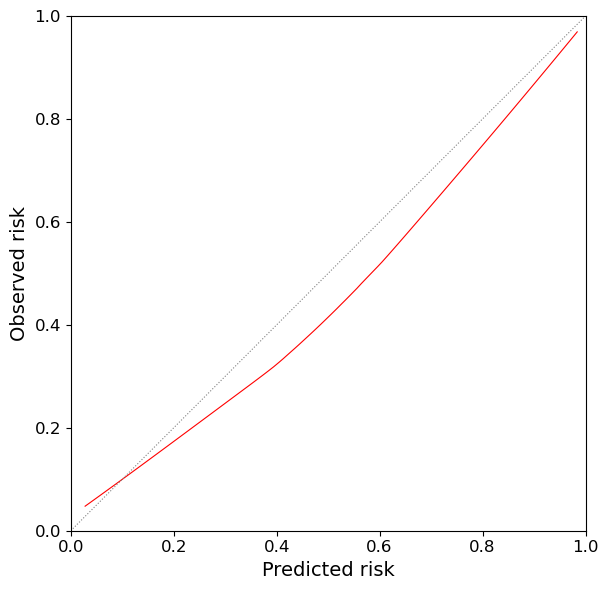

In [73]:
# Compute the calibration curve
prob_true, prob_pred = calibration_curve(y_eval_deterioration, y_eval_deterioration_pred_proba, n_bins = 100)

# Apply LOESS smoothing
loess_fraction = 0.8  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration

# Set limits and ensure equal unit lengths on both axes
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable = 'box')  # This ensures equal scaling of both axes

plt.xlabel('Predicted risk', fontsize = 14)
plt.ylabel('Observed risk', fontsize = 14)
plt.xticks(fontsize = 12)  # Adjust font size for x-axis tick labels
plt.yticks(fontsize = 12)  # Adjust font size for y-axis tick labels
#plt.title('Calibration Plot', fontsize=16)
#plt.legend(loc="best", fontsize = 12)
plt.grid(False)
plt.tight_layout()

# Show plot
plt.grid(False)
plt.savefig(r'T:\Projects\NAPKON\projects\CROSS_mortality\python\results\figures\xgboost_mortality\calibration_plot_12FeaturesbyFscore.png', bbox_inches='tight')
plt.show()

### Brier score

In [74]:
# Get probabilities for the positive class
y_eval_deterioration_pred_proba = best_lasso_icu.predict_proba(X_eval_deterioration)[:, 1]

# Calculate Brier score
brier_score = brier_score_loss(y_eval_deterioration, y_eval_deterioration_pred_proba)

print(f"Brier Score: {brier_score}")

Brier Score: 0.1698336693503851


### Decision curve analysis

C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\381627141.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  nb = tp / len(data) - (fp / len(data)) * (threshold / (1 - threshold))
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\381627141.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  nb = tp / len(data) - (fp / len(data)) * (threshold / (1 - threshold))
C:\Users\xiangw\AppData\Local\Temp\ipykernel_21212\381627141.py:18: RuntimeWarning: divide by zero encountered in divide
  return prevalence - (1 - prevalence) * (threshold_probs / (1 - threshold_probs))


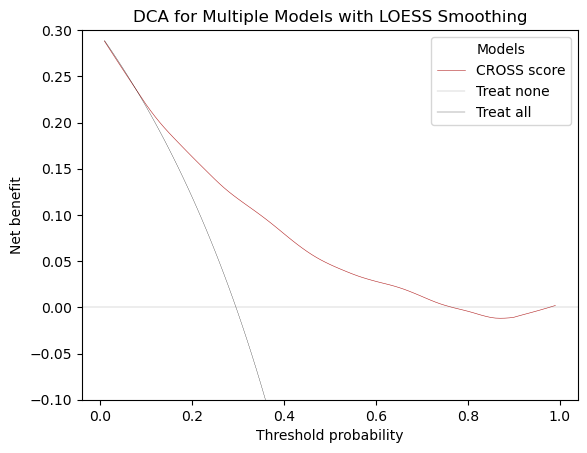

In [75]:
# Assuming `y_eval_icu` (ground truth) and `y_eval_icu_pred_proba` (predicted probabilities) are available
dat_all = pd.DataFrame({'deterioration': y_eval_deterioration, 'der_pred_cross': y_eval_deterioration_pred_proba})

prevalence = prevalence

# Function to calculate net benefit for decision curve analysis
def decision_curve_analysis(data, threshold_probs, prevalence = prevalence):
    net_benefits = []
    for threshold in threshold_probs:
        tp = np.sum((data['der_pred_cross'] >= threshold) & (data['deterioration'] == 1))
        fp = np.sum((data['der_pred_cross'] >= threshold) & (data['deterioration'] == 0))
        nb = tp / len(data) - (fp / len(data)) * (threshold / (1 - threshold))
        net_benefits.append(nb)
    return pd.DataFrame({'threshold': threshold_probs, 'net_benefit': net_benefits})

# Function to calculate the net benefit for the "Treat All" strategy
def treat_all_line(threshold_probs, prevalence):
    return prevalence - (1 - prevalence) * (threshold_probs / (1 - threshold_probs))

# Define threshold probabilities for DCA
threshold_probs = np.linspace(0.01, 1.0, 100)

# Perform decision curve analysis
df_plot = decision_curve_analysis(dat_all, threshold_probs, prevalence)

# Calculate the "Treat All" line using the correct formula
df_plot['treat_all'] = treat_all_line(threshold_probs, prevalence)

# Apply LOESS smoothing to net benefit
loess_smoothed = lowess(df_plot['net_benefit'], df_plot['threshold'], frac=0.2)  # frac controls the amount of smoothing

# Prepare smoothed results for plotting
smoothed_df = pd.DataFrame(loess_smoothed, columns=['threshold', 'smoothed_net_benefit'])

# Color and linetype mapping for the plot
color_labels = {
    'der_pred_cross': '#B22222',  # Red color for CROSS score
    'Treat All': '#000000',        # Black color for Treat All
    'Treat None': '#808080'        # Grey color for Treat None
}
linetype_labels = {
    'der_pred_cross': 'solid',
    'Treat All': 'solid',
    'Treat None': 'solid'
}
legend_labels = {
    'der_pred_cross': 'CROSS score',
    'Treat All': 'Treat all',
    'Treat None': 'Treat none'
}

# Plot the LOESS smoothed net benefit for CROSS score (DCA curve)
sns.lineplot(data=smoothed_df, 
             x='threshold', 
             y='smoothed_net_benefit', 
             label=legend_labels['der_pred_cross'], 
             color=color_labels['der_pred_cross'], 
             linestyle=linetype_labels['der_pred_cross'], 
             linewidth=0.4)  

# Plot the Treat None line (always at y = 0)
plt.axhline(y=0, 
            color=color_labels['Treat None'], 
            linestyle='solid', 
            label=legend_labels['Treat None'], 
            linewidth=0.2)  

# Plot the Treat All line (calculated as a slant line)
sns.lineplot(x=threshold_probs, 
             y=df_plot['treat_all'], 
             label=legend_labels['Treat All'], 
             color=color_labels['Treat All'], 
             linestyle=linetype_labels['Treat All'], 
             linewidth=0.2)  

# Customize plot
plt.title("DCA for Multiple Models with LOESS Smoothing")
plt.xlabel("Threshold probability")
plt.ylabel("Net benefit")
plt.ylim(-0.1, 0.3)  # Adjust y-limits if necessary
plt.legend(title="Models")

# Show plot
plt.show()